In [249]:
import scipy.io
import pandas as pd

import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats

In [250]:
mat = scipy.io.loadmat('Oxford_Battery_Degradation_Dataset_1.mat')

In [251]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [252]:
input_data = [[], []]

In [253]:
for i in range(0, 83):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell1"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[0].append(i)
    input_data[1].append(curr)
    print(curr)

724.1208914093187
714.5350426825697
709.8543464961379
707.0393485194566
702.2342863457235
698.8440013150872
695.4850715278354
691.6932258285015
687.6300422440017
684.2488065128581
681.0607272448832
677.8486336050008
674.7281887527703
671.556081370731
668.6709791990864
nan
662.9724287937147
nan
656.4621886431951
653.2751603988444
650.1157422984008
647.1105116933119
644.0549444561768
640.7948747304991
638.1391374235501
635.3790871886936
632.3887851445143
629.9572173218418
627.3439847566834
624.1095617381898
622.448908879052
619.9778349196439
617.3031788485108
615.3476618618469
nan
611.340570310974
609.7195455723199
605.1998563440754
604.1349210491537
602.8723865926853
600.9075598059693
598.2787878589917
596.7047192299974
594.08713143121
591.9284795739374
589.3588371850756
588.0833074787903
nan
584.2617834340922
nan
579.5968326875441
577.6717759357741
575.5147033984103
574.7467034891866
572.8103356272312
568.9614464139573
568.632337365943
566.7898372362026
564.7710880962863
563.0229675191

In [254]:
df_input = pd.DataFrame(input_data).transpose()
df_input = df_input.rename(columns = {0: "cycle", 1:"q_value"})
df_input

,cycle,q_value
0,0.0,724.120891
1,1.0,714.535043
2,2.0,709.854346
3,3.0,707.039349
4,4.0,702.234286
...,...,...
78,78.0,534.715467
79,79.0,534.731729
80,80.0,533.296215
81,81.0,529.457138


In [255]:
df_input['interpolate_spline'] = df_input['q_value'].interpolate(option='spline')
df_input

,cycle,q_value,interpolate_spline
0,0.0,724.120891,724.120891
1,1.0,714.535043,714.535043
2,2.0,709.854346,709.854346
3,3.0,707.039349,707.039349
4,4.0,702.234286,702.234286
...,...,...,...
78,78.0,534.715467,534.715467
79,79.0,534.731729,534.731729
80,80.0,533.296215,533.296215
81,81.0,529.457138,529.457138


In [256]:
df_input = df_input.drop("cycle", axis = 1)
df_input = df_input.drop("q_value", axis = 1)

In [257]:
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df_input.values)
label_sc.fit(df_input.iloc[:,0].values.reshape(-1,1))


MinMaxScaler()

In [258]:
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df_input.shape[1]))
labels = np.zeros(len(data)-lookback)


In [259]:
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i,0]
inputs = inputs.reshape(-1,lookback,df_input.shape[1])
labels = labels.reshape(-1,1)

In [260]:
test_portion = int(0.1*len(inputs))

train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]

test_x = (inputs[-test_portion:])
test_y = (labels[-test_portion:])

In [261]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [262]:
device = torch.device("cpu")

In [263]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [264]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=500, model_type="GRU"):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [265]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1/500 Done, Total Loss: 0.10398967191576958
Total Time Elapsed: 0.359375 seconds
Epoch 2/500 Done, Total Loss: 0.039967626333236694
Total Time Elapsed: 0.28125 seconds
Epoch 3/500 Done, Total Loss: 0.043805282562971115
Total Time Elapsed: 0.265625 seconds
Epoch 4/500 Done, Total Loss: 0.02899453043937683
Total Time Elapsed: 0.375 seconds
Epoch 5/500 Done, Total Loss: 0.028806705959141254
Total Time Elapsed: 0.3125 seconds
Epoch 6/500 Done, Total Loss: 0.022477000951766968
Total Time Elapsed: 0.34375 seconds
Epoch 7/500 Done, Total Loss: 0.018695738166570663
Total Time Elapsed: 0.3125 seconds
Epoch 8/500 Done, Total Loss: 0.011182979214936495
Total Time Elapsed: 0.359375 seconds
Epoch 9/500 Done, Total Loss: 0.006084291497245431
Total Time Elapsed: 0.328125 seconds
Epoch 10/500 Done, Total Loss: 0.0012807908788090572
Total Time Elapsed: 0.328125 seconds
Epoch 11/500 Done, Total Loss: 0.0033018208341673017
Total Time Elapsed: 0.1875 seconds
Epoch 12/5

In [266]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.0
sMAPE: 0.14185771729202037%


In [267]:
gru_outputs

[array([539.8204 , 538.88617, 538.03345, 537.12445, 536.28564, 535.5311 ,
        534.6935 ], dtype=float32)]

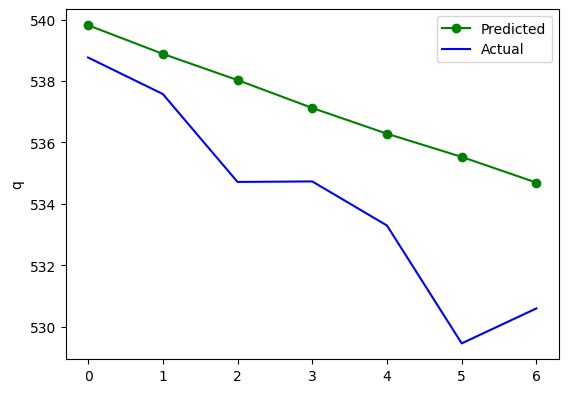

In [269]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('q')
plt.legend()